In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Class names of CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Original training images shape: {x_train_full.shape}")
print(f"Original training labels shape: {y_train_full.shape}")
print(f"Original test images shape: {x_test.shape}")
print(f"Original test labels shape: {y_test.shape}")



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Original training images shape: (50000, 32, 32, 3)
Original training labels shape: (50000, 1)
Original test images shape: (10000, 32, 32, 3)
Original test labels shape: (10000, 1)


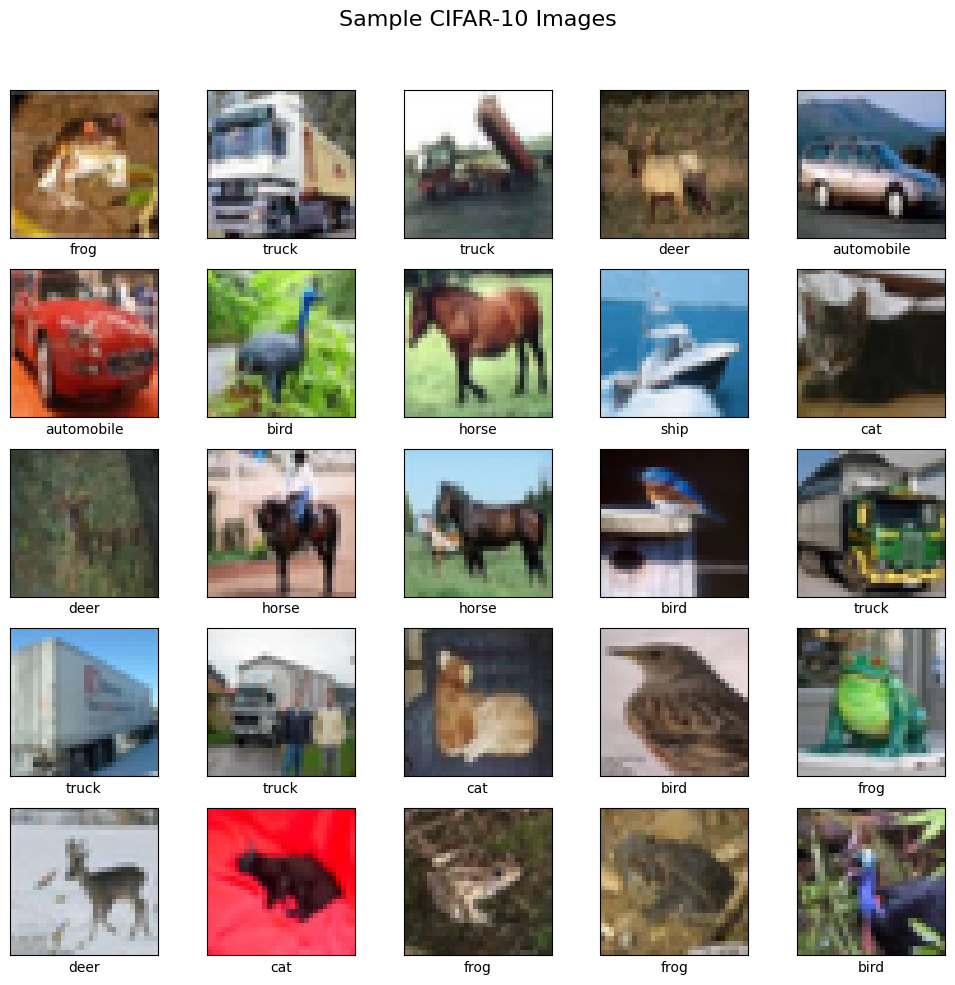

<Figure size 1000x600 with 0 Axes>

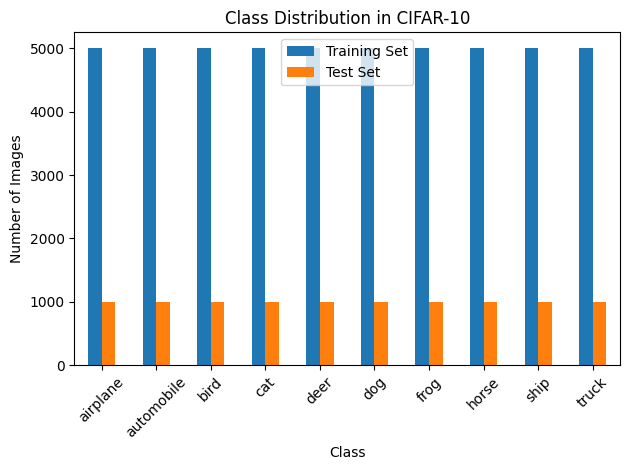

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#EDA
# Sample images visualization
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_full[i])
    # The CIFAR labels happen to be arrays, which is why we need the extra index
    plt.xlabel(class_names[y_train_full[i][0]])
plt.tight_layout()
plt.suptitle('Sample CIFAR-10 Images', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Analyze class distribution
plt.figure(figsize=(10, 6))
train_counts = np.bincount(y_train_full.flatten())
test_counts = np.bincount(y_test.flatten())
df = pd.DataFrame({
    'Training Set': train_counts,
    'Test Set': test_counts
}, index=class_names)
df.plot(kind='bar')
plt.title('Class Distribution in CIFAR-10')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Split train set to create validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

# Preprocessing
# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

print(f"Normalized training images shape: {x_train.shape}")
print(f"One-hot encoded training labels shape: {y_train.shape}")



Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Normalized training images shape: (40000, 32, 32, 3)
One-hot encoded training labels shape: (40000, 10)


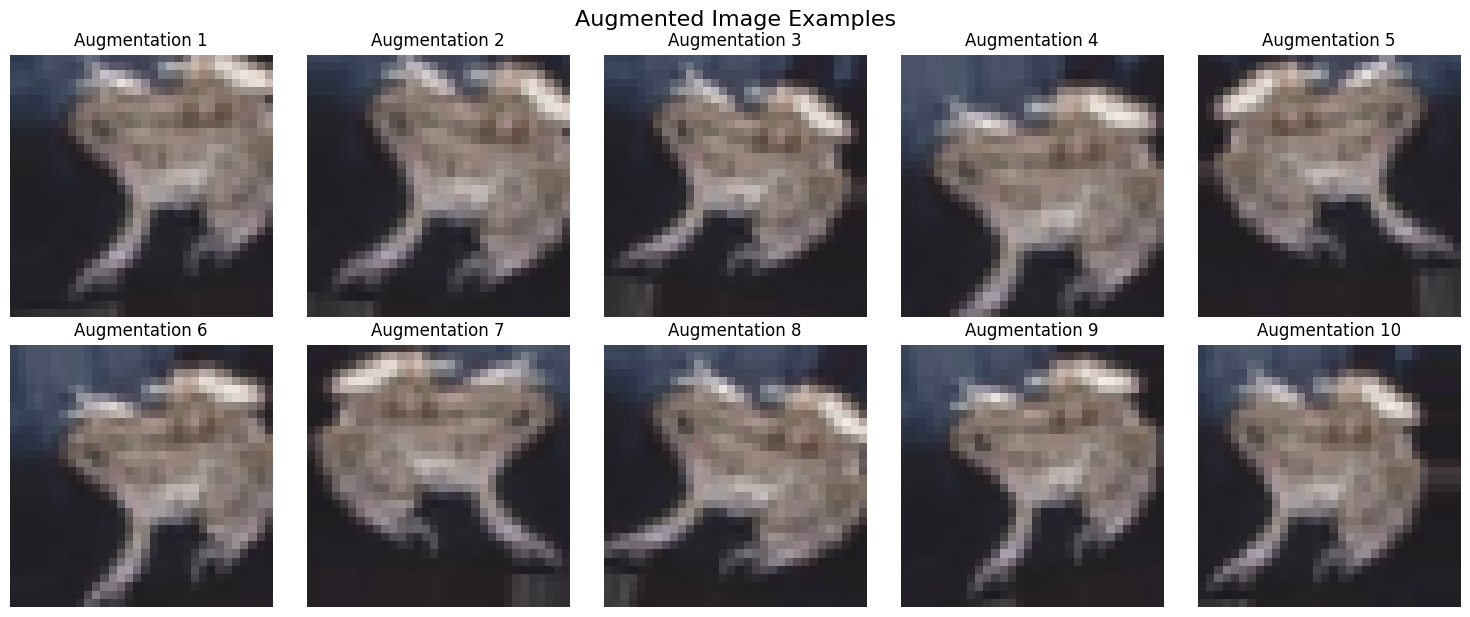

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Visualize augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

sample_img = x_train[0]  # Taking the first image
sample_img = np.expand_dims(sample_img, 0)  # Add batch dimension

augmented_images = [next(datagen.flow(sample_img, batch_size=1))[0] for _ in range(10)]

for i, aug_img in enumerate(augmented_images):
    axes[i].imshow(aug_img)
    axes[i].axis('off')
    axes[i].set_title(f'Augmentation {i+1}')

plt.tight_layout()
plt.suptitle('Augmented Image Examples', y=1.02, fontsize=16)
plt.show()

In [8]:
import tensorflow as tf
# Create TensorFlow datasets for efficient training
BATCH_SIZE = 32

# Training dataset with augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Apply data augmentation to training dataset
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset (no augmentation)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset preparation complete!")
print(f"Training batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")
print(f"Test batches: {len(list(test_dataset))}")

Dataset preparation complete!
Training batches: 1250
Validation batches: 313
Test batches: 313


In [9]:
# 7. Summary of Data Preparation Steps
print("\nData Preparation Summary:")
print("-------------------------")
print(f"Original Dataset Size: {len(x_train_full)} training, {len(x_test)} testing")
print(f"After Split: {len(x_train)} training, {len(x_val)} validation, {len(x_test)} testing")
print(f"Image Dimensions: {x_train.shape[1:]} (normalized to [0,1])")
print(f"Number of Classes: {len(class_names)}")
print(f"Data Augmentation: Rotation, Shift, Flip, Zoom")
print(f"Batch Size: {BATCH_SIZE}")


Data Preparation Summary:
-------------------------
Original Dataset Size: 50000 training, 10000 testing
After Split: 40000 training, 10000 validation, 10000 testing
Image Dimensions: (32, 32, 3) (normalized to [0,1])
Number of Classes: 10
Data Augmentation: Rotation, Shift, Flip, Zoom
Batch Size: 32


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time

#defining the model mobilenet
def build_mobilenet_model():
    # Input shape for CIFAR-10 images
    input_shape = (32, 32, 3)
    inputs = Input(shape=input_shape)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = build_mobilenet_model()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # reduce LR by 80% when triggered
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    # Save model checkpoints
    ModelCheckpoint(
        filepath='cifar10_mobilenet_checkpoint.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the model

epochs = 30
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks
)



<ipython-input-10-e88628d6b267>:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,620,106 (9.99 MB)

 Trainable params: 362,122 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2356 - loss: 2.0802 - precision: 0.4740 - recall: 0.0173
Epoch 1: val_accuracy improved from -inf to 0.31890, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.2358 - loss: 2.0796 - precision: 0.4744 - recall: 0.0174 - val_accuracy: 0.3189 - val_loss: 1.8665 - val_precision: 0.6053 - val_recall: 0.0388 - learning_rate: 0.0010
Epoch 2/30
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3058 - loss: 1.9035 - precision: 0.5513 - recall: 0.0450
Epoch 2: val_accuracy improved from 0.31890 to 0.32610, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3058 - loss: 1.9034 - precision: 0.5514 - recall: 0.0450 - val_accuracy: 0.3261 - val_loss: 1.8391 - val_precision: 0.6170 - val_recall: 0.0464 - learning_rate: 0.0010
Epoch 3/30
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3234 - loss: 1.8626 - precision: 0.5619 - recall: 0.0569
Epoch 3: val_accuracy improved from 0.32610 to 0.33270, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3234 - loss: 1.8626 - precision: 0.5619 - recall: 0.0569 - val_accuracy: 0.3327 - val_loss: 1.8192 - val_precision: 0.6375 - val_recall: 0.0582 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3299 - loss: 1.8483 - precision: 0.5912 - recall: 0.0652
Epoch 4: val_accuracy improved from 0.33270 to 0.33490, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3299 - loss: 1.8483 - precision: 0.5912 - recall: 0.0652 - val_accuracy: 0.3349 - val_loss: 1.8117 - val_precision: 0.6330 - val_recall: 0.0690 - learning_rate: 0.0010
Epoch 5/30
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3320 - loss: 1.8385 - precision: 0.6083 - recall: 0.0693
Epoch 5: val_accuracy improved from 0.33490 to 0.33750, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3320 - loss: 1.8385 - precision: 0.6083 - recall: 0.0692 - val_accuracy: 0.3375 - val_loss: 1.8040 - val_precision: 0.6507 - val_recall: 0.0531 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3349 - loss: 1.8276 - precision: 0.5983 - recall: 0.0703
Epoch 6: val_accuracy improved from 0.33750 to 0.34280, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3349 - loss: 1.8276 - precision: 0.5983 - recall: 0.0703 - val_accuracy: 0.3428 - val_loss: 1.7953 - val_precision: 0.6307 - val_recall: 0.0690 - learning_rate: 0.0010
Epoch 7/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3326 - loss: 1.8243 - precision: 0.5949 - recall: 0.0695
Epoch 7: val_accuracy did not improve from 0.34280
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3326 - loss: 1.8243 - precision: 0.5949 - recall: 0.0695 - val_accuracy: 0.3425 - val_loss: 1.7928 - val_precision: 0.6378 - val_recall: 0.0671 - learning_rate: 0.0010
Epoch 8/30
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3393 - loss: 1.8156 - precision: 0.6031 - recall: 0.0777
Epoch 8: val_accuracy did not improve from 0.34280
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3393 - loss: 1.8156 - precision: 0.6031 - recall: 0.0777 - val_accuracy: 0.3403 - val_loss: 1.7864 - val_precision: 0.6463 - val_recall: 0

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3404 - loss: 1.8013 - precision: 0.6197 - recall: 0.0829 - val_accuracy: 0.3467 - val_loss: 1.7835 - val_precision: 0.6741 - val_recall: 0.0602 - learning_rate: 0.0010
Epoch 10/30
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3437 - loss: 1.8070 - precision: 0.6195 - recall: 0.0806
Epoch 10: val_accuracy did not improve from 0.34670
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3437 - loss: 1.8069 - precision: 0.6195 - recall: 0.0806 - val_accuracy: 0.3463 - val_loss: 1.7794 - val_precision: 0.6222 - val_recall: 0.0797 - learning_rate: 0.0010
Epoch 11/30
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3430 - loss: 1.7977 - precision: 0.6017 - recall: 0.0819
Epoch 11: val_accuracy did not improve from 0.34670
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3430 - loss: 1.7977 - precision: 0.6017 - recall: 0.0819 - val_accuracy: 0.3454 - val_loss: 1.7818 - val_precision: 0.6225 - val_recal

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3512 - loss: 1.7857 - precision: 0.6104 - recall: 0.0862 - val_accuracy: 0.3497 - val_loss: 1.7801 - val_precision: 0.6411 - val_recall: 0.0793 - learning_rate: 0.0010
Epoch 13/30
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3519 - loss: 1.7954 - precision: 0.6231 - recall: 0.0856
Epoch 13: val_accuracy improved from 0.34970 to 0.35330, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3519 - loss: 1.7954 - precision: 0.6231 - recall: 0.0856 - val_accuracy: 0.3533 - val_loss: 1.7722 - val_precision: 0.6462 - val_recall: 0.0831 - learning_rate: 0.0010
Epoch 14/30
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3462 - loss: 1.7956 - precision: 0.6068 - recall: 0.0879
Epoch 14: val_accuracy did not improve from 0.35330
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3462 - loss: 1.7956 - precision: 0.6068 - recall: 0.0879 - val_accuracy: 0.3493 - val_loss: 1.7795 - val_precision: 0.6332 - val_recall: 0.0877 - learning_rate: 0.0010
Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3517 - loss: 1.7828 - precision: 0.6083 - recall: 0.0911
Epoch 15: val_accuracy did not improve from 0.35330
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.3517 - loss: 1.7828 - precision: 0.6083 - recall: 0.0911 - val_accuracy: 0.3495 - val_loss: 1.7723 - val_precision: 0.6517 - val_reca

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3474 - loss: 1.7875 - precision: 0.6260 - recall: 0.0905 - val_accuracy: 0.3543 - val_loss: 1.7709 - val_precision: 0.6614 - val_recall: 0.0756 - learning_rate: 0.0010
Epoch 17/30
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3578 - loss: 1.7743 - precision: 0.6067 - recall: 0.0911
Epoch 17: val_accuracy improved from 0.35430 to 0.35500, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3577 - loss: 1.7743 - precision: 0.6068 - recall: 0.0911 - val_accuracy: 0.3550 - val_loss: 1.7702 - val_precision: 0.6621 - val_recall: 0.0866 - learning_rate: 0.0010
Epoch 18/30
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3551 - loss: 1.7837 - precision: 0.6173 - recall: 0.0922
Epoch 18: val_accuracy did not improve from 0.35500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3551 - loss: 1.7836 - precision: 0.6173 - recall: 0.0922 - val_accuracy: 0.3513 - val_loss: 1.7706 - val_precision: 0.6426 - val_recall: 0.0847 - learning_rate: 0.0010
Epoch 19/30
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3542 - loss: 1.7715 - precision: 0.6271 - recall: 0.0957
Epoch 19: val_accuracy did not improve from 0.35500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3542 - loss: 1.7715 - precision: 0.6271 - recall: 0.0957 - val_accuracy: 0.3521 - val_loss: 1.7692 - val_precision: 0.6736 - val_recal

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3544 - loss: 1.7699 - precision: 0.6198 - recall: 0.0927 - val_accuracy: 0.3552 - val_loss: 1.7699 - val_precision: 0.6409 - val_recall: 0.0830 - learning_rate: 0.0010
Epoch 21/30
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3567 - loss: 1.7775 - precision: 0.6101 - recall: 0.0934
Epoch 21: val_accuracy improved from 0.35520 to 0.35670, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3567 - loss: 1.7775 - precision: 0.6101 - recall: 0.0934 - val_accuracy: 0.3567 - val_loss: 1.7689 - val_precision: 0.6482 - val_recall: 0.0796 - learning_rate: 0.0010
Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3532 - loss: 1.7687 - precision: 0.6146 - recall: 0.0963
Epoch 22: val_accuracy did not improve from 0.35670
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.3532 - loss: 1.7687 - precision: 0.6146 - recall: 0.0963 - val_accuracy: 0.3538 - val_loss: 1.7706 - val_precision: 0.6626 - val_recall: 0.0752 - learning_rate: 0.0010
Epoch 23/30
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3555 - loss: 1.7724 - precision: 0.6244 - recall: 0.0957
Epoch 23: val_accuracy improved from 0.35670 to 0.35710, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3555 - loss: 1.7723 - precision: 0.6244 - recall: 0.0957 - val_accuracy: 0.3571 - val_loss: 1.7650 - val_precision: 0.6389 - val_recall: 0.0943 - learning_rate: 0.0010
Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3600 - loss: 1.7706 - precision: 0.6129 - recall: 0.0992
Epoch 24: val_accuracy did not improve from 0.35710
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.3600 - loss: 1.7706 - precision: 0.6129 - recall: 0.0992 - val_accuracy: 0.3551 - val_loss: 1.7662 - val_precision: 0.6597 - val_recall: 0.0787 - learning_rate: 0.0010
Epoch 25/30
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3518 - loss: 1.7734 - precision: 0.6269 - recall: 0.0971
Epoch 25: val_accuracy improved from 0.35710 to 0.36070, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.3518 - loss: 1.7734 - precision: 0.6269 - recall: 0.0971 - val_accuracy: 0.3607 - val_loss: 1.7646 - val_precision: 0.6505 - val_recall: 0.0856 - learning_rate: 0.0010
Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3627 - loss: 1.7624 - precision: 0.6282 - recall: 0.1051
Epoch 26: val_accuracy did not improve from 0.36070
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3627 - loss: 1.7624 - precision: 0.6282 - recall: 0.1051 - val_accuracy: 0.3537 - val_loss: 1.7694 - val_precision: 0.6540 - val_recall: 0.0843 - learning_rate: 0.0010
Epoch 27/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3620 - loss: 1.7595 - precision: 0.6142 - recall: 0.1014
Epoch 27: val_accuracy did not improve from 0.36070
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3620 - loss: 1.7595 - precision: 0.6142 - recall: 0.1014 - val_accuracy: 0.3576 - val_loss: 1.7669 - val_precision: 0.6517 - val_rec

In [11]:
# Unfreeze some of the layers and fine-tune with a lower learning rate
# Unfreeze the last few layers of MobileNetV2
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

fine_tune_epochs = 20
fine_tune_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

Epoch 1/20
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2281 - loss: 6.0527 - precision_1: 0.2686 - recall_1: 0.1587
Epoch 1: val_accuracy did not improve from 0.36070
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.2282 - loss: 6.0470 - precision_1: 0.2688 - recall_1: 0.1587 - val_accuracy: 0.1437 - val_loss: 2.5018 - val_precision_1: 0.3727 - val_recall_1: 0.0227 - learning_rate: 1.0000e-04
Epoch 2/20
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3008 - loss: 2.0192 - precision_1: 0.5135 - recall_1: 0.0974
Epoch 2: val_accuracy did not improve from 0.36070
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3009 - loss: 2.0189 - precision_1: 0.5136 - recall_1: 0.0975 - val_accuracy: 0.3350 - val_loss: 1.8916 - val_precision_1: 0.6152 - val_recall_1: 0.0339 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3687 - loss: 1.7734 - precision_1: 0.6162 - recall_1: 0.1470
Epoch 3: val_accuracy improved fr

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.3687 - loss: 1.7734 - precision_1: 0.6162 - recall_1: 0.1470 - val_accuracy: 0.4370 - val_loss: 1.5670 - val_precision_1: 0.7533 - val_recall_1: 0.1429 - learning_rate: 1.0000e-04
Epoch 4/20
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4186 - loss: 1.6398 - precision_1: 0.6501 - recall_1: 0.1933
Epoch 4: val_accuracy improved from 0.43700 to 0.46420, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4186 - loss: 1.6398 - precision_1: 0.6502 - recall_1: 0.1933 - val_accuracy: 0.4642 - val_loss: 1.4785 - val_precision_1: 0.7487 - val_recall_1: 0.2163 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4576 - loss: 1.5373 - precision_1: 0.6808 - recall_1: 0.2374
Epoch 5: val_accuracy improved from 0.46420 to 0.51330, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4576 - loss: 1.5373 - precision_1: 0.6808 - recall_1: 0.2375 - val_accuracy: 0.5133 - val_loss: 1.3792 - val_precision_1: 0.7784 - val_recall_1: 0.2533 - learning_rate: 1.0000e-04
Epoch 6/20
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4839 - loss: 1.4731 - precision_1: 0.6959 - recall_1: 0.2680
Epoch 6: val_accuracy improved from 0.51330 to 0.52960, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4839 - loss: 1.4730 - precision_1: 0.6959 - recall_1: 0.2681 - val_accuracy: 0.5296 - val_loss: 1.3436 - val_precision_1: 0.7561 - val_recall_1: 0.2992 - learning_rate: 1.0000e-04
Epoch 7/20
1244/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5038 - loss: 1.4149 - precision_1: 0.7138 - recall_1: 0.2944
Epoch 7: val_accuracy improved from 0.52960 to 0.55250, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.5039 - loss: 1.4149 - precision_1: 0.7139 - recall_1: 0.2944 - val_accuracy: 0.5525 - val_loss: 1.2783 - val_precision_1: 0.7814 - val_recall_1: 0.3263 - learning_rate: 1.0000e-04
Epoch 8/20
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5269 - loss: 1.3750 - precision_1: 0.7271 - recall_1: 0.3284
Epoch 8: val_accuracy improved from 0.55250 to 0.55720, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5269 - loss: 1.3749 - precision_1: 0.7271 - recall_1: 0.3284 - val_accuracy: 0.5572 - val_loss: 1.2571 - val_precision_1: 0.7563 - val_recall_1: 0.3656 - learning_rate: 1.0000e-04
Epoch 9/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5360 - loss: 1.3368 - precision_1: 0.7324 - recall_1: 0.3445
Epoch 9: val_accuracy improved from 0.55720 to 0.56680, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5360 - loss: 1.3368 - precision_1: 0.7324 - recall_1: 0.3445 - val_accuracy: 0.5668 - val_loss: 1.2341 - val_precision_1: 0.7694 - val_recall_1: 0.3704 - learning_rate: 1.0000e-04
Epoch 10/20
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5527 - loss: 1.3043 - precision_1: 0.7411 - recall_1: 0.3642
Epoch 10: val_accuracy did not improve from 0.56680
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5527 - loss: 1.3043 - precision_1: 0.7411 - recall_1: 0.3642 - val_accuracy: 0.5668 - val_loss: 1.2368 - val_precision_1: 0.7476 - val_recall_1: 0.3829 - learning_rate: 1.0000e-04
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5620 - loss: 1.2810 - precision_1: 0.7527 - recall_1: 0.3778
Epoch 11: val_accuracy improved from 0.56680 to 0.57950, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5620 - loss: 1.2810 - precision_1: 0.7527 - recall_1: 0.3778 - val_accuracy: 0.5795 - val_loss: 1.2029 - val_precision_1: 0.7580 - val_recall_1: 0.4015 - learning_rate: 1.0000e-04
Epoch 12/20
1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5777 - loss: 1.2320 - precision_1: 0.7575 - recall_1: 0.4003
Epoch 12: val_accuracy improved from 0.57950 to 0.58500, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5777 - loss: 1.2320 - precision_1: 0.7575 - recall_1: 0.4003 - val_accuracy: 0.5850 - val_loss: 1.1735 - val_precision_1: 0.7721 - val_recall_1: 0.4202 - learning_rate: 1.0000e-04
Epoch 13/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5910 - loss: 1.2048 - precision_1: 0.7600 - recall_1: 0.4137
Epoch 13: val_accuracy improved from 0.58500 to 0.59100, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5910 - loss: 1.2048 - precision_1: 0.7600 - recall_1: 0.4137 - val_accuracy: 0.5910 - val_loss: 1.1830 - val_precision_1: 0.7738 - val_recall_1: 0.4015 - learning_rate: 1.0000e-04
Epoch 14/20
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5887 - loss: 1.2001 - precision_1: 0.7633 - recall_1: 0.4144
Epoch 14: val_accuracy did not improve from 0.59100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5888 - loss: 1.2000 - precision_1: 0.7633 - recall_1: 0.4144 - val_accuracy: 0.5898 - val_loss: 1.1791 - val_precision_1: 0.7813 - val_recall_1: 0.4159 - learning_rate: 1.0000e-04
Epoch 15/20
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5972 - loss: 1.1642 - precision_1: 0.7637 - recall_1: 0.4265
Epoch 15: val_accuracy improved from 0.59100 to 0.61160, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5972 - loss: 1.1642 - precision_1: 0.7637 - recall_1: 0.4265 - val_accuracy: 0.6116 - val_loss: 1.1274 - val_precision_1: 0.7895 - val_recall_1: 0.4381 - learning_rate: 1.0000e-04
Epoch 16/20
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6033 - loss: 1.1504 - precision_1: 0.7637 - recall_1: 0.4400
Epoch 16: val_accuracy did not improve from 0.61160
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6034 - loss: 1.1504 - precision_1: 0.7637 - recall_1: 0.4400 - val_accuracy: 0.6027 - val_loss: 1.1374 - val_precision_1: 0.7858 - val_recall_1: 0.4336 - learning_rate: 1.0000e-04
Epoch 17/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6116 - loss: 1.1353 - precision_1: 0.7717 - recall_1: 0.4484
Epoch 17: val_accuracy improved from 0.61160 to 0.61470, saving model to cifar10_mobilenet_checkpoint.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6116 - loss: 1.1353 - precision_1: 0.7717 - recall_1: 0.4484 - val_accuracy: 0.6147 - val_loss: 1.1069 - val_precision_1: 0.8010 - val_recall_1: 0.4322 - learning_rate: 1.0000e-04
Epoch 18/20
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6165 - loss: 1.1118 - precision_1: 0.7760 - recall_1: 0.4611
Epoch 18: val_accuracy did not improve from 0.61470
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6165 - loss: 1.1118 - precision_1: 0.7760 - recall_1: 0.4611 - val_accuracy: 0.6106 - val_loss: 1.1219 - val_precision_1: 0.7753 - val_recall_1: 0.4496 - learning_rate: 1.0000e-04
Epoch 19/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6234 - loss: 1.0986 - precision_1: 0.7764 - recall_1: 0.4691
Epoch 19: val_accuracy did not improve from 0.61470
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6234 - loss: 1.0986 - precision_1: 0.7764 - recall_1: 0.4691 - val_accuracy: 0.6122 - val_loss: 1.1

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6242 - loss: 1.0847 - precision_1: 0.7784 - recall_1: 0.4753 - val_accuracy: 0.6207 - val_loss: 1.1286 - val_precision_1: 0.7672 - val_recall_1: 0.4572 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 17.


In [12]:
# Combine training histories
for key in history.history:
    if key in fine_tune_history.history:
        history.history[key].extend(fine_tune_history.history[key])

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

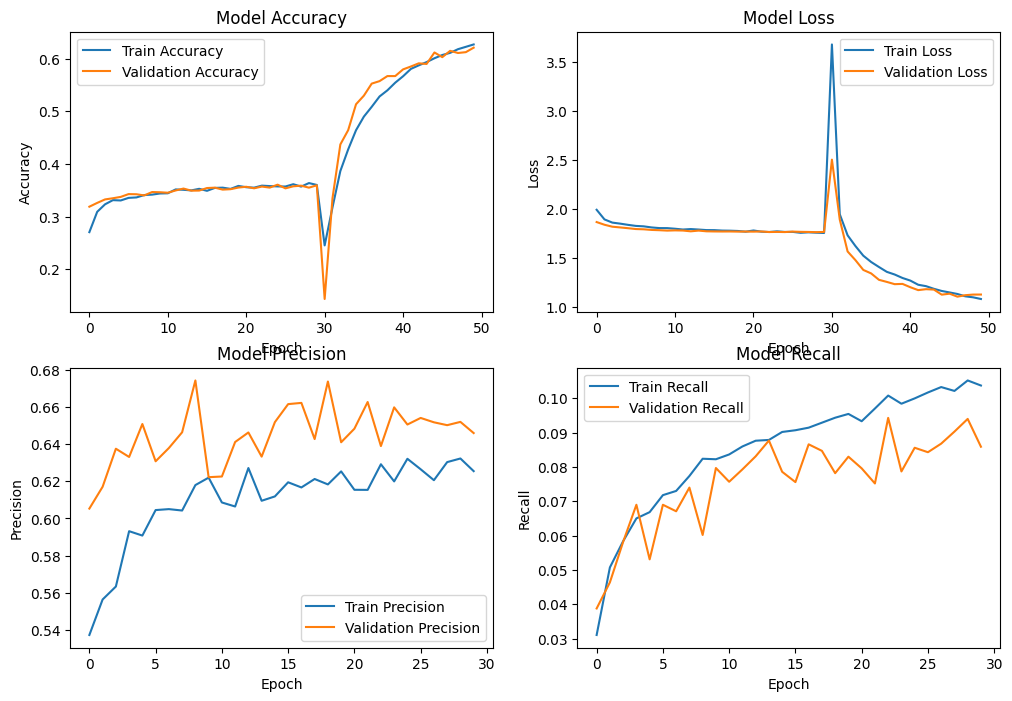

In [16]:
# Visualize training history
plt.figure(figsize=(12, 8))
# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot training & validation recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

In [21]:
#Evaluate the model on test set
print("Evaluating model on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
# Calculate F1 score (harmonic mean of precision and recall)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"F1 Score: {f1_score:.4f}")

Evaluating model on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6070 - loss: 1.1356 - precision_1: 0.7898 - recall_1: 0.4325
Test Loss: 1.1357
Test Accuracy: 0.6084
Test Precision: 0.7944
Test Recall: 0.4294
F1 Score: 0.5575


In [18]:
# Generate predictions for confusion matrix
print("Generating confusion matrix...")
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_dataset], axis=0), axis=1)

Generating confusion matrix...
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


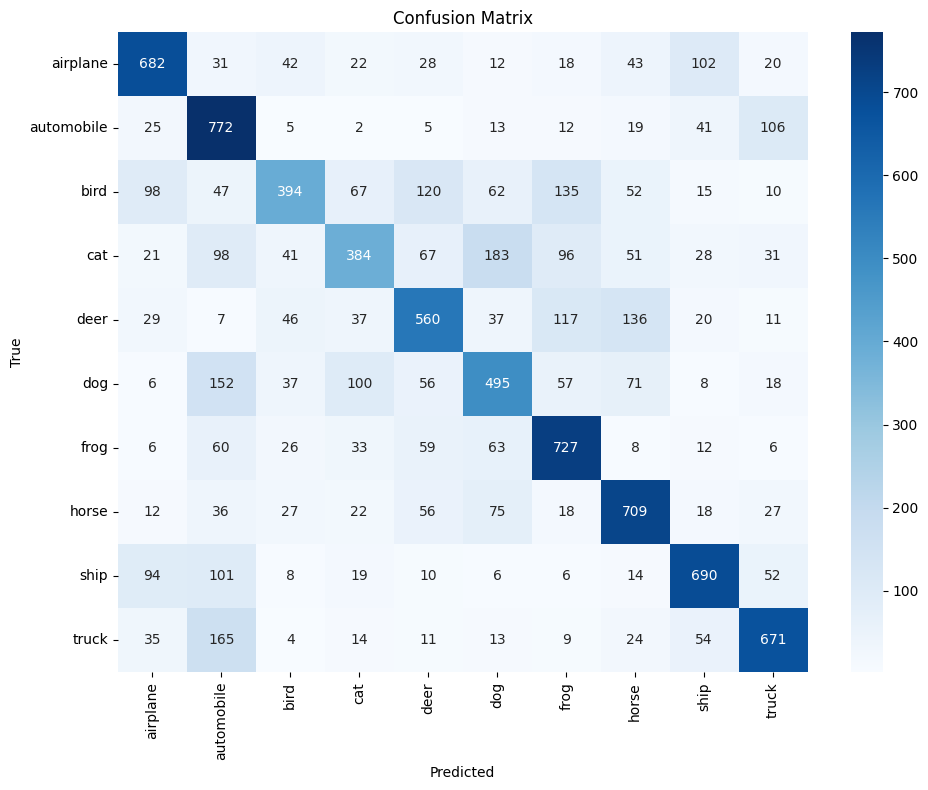

In [23]:
# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [20]:
# Generate classification report
print("Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.68      0.68      1000
  automobile       0.53      0.77      0.63      1000
        bird       0.63      0.39      0.48      1000
         cat       0.55      0.38      0.45      1000
        deer       0.58      0.56      0.57      1000
         dog       0.52      0.49      0.51      1000
        frog       0.61      0.73      0.66      1000
       horse       0.63      0.71      0.67      1000
        ship       0.70      0.69      0.69      1000
       truck       0.70      0.67      0.69      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.60     10000
weighted avg       0.61      0.61      0.60     10000



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


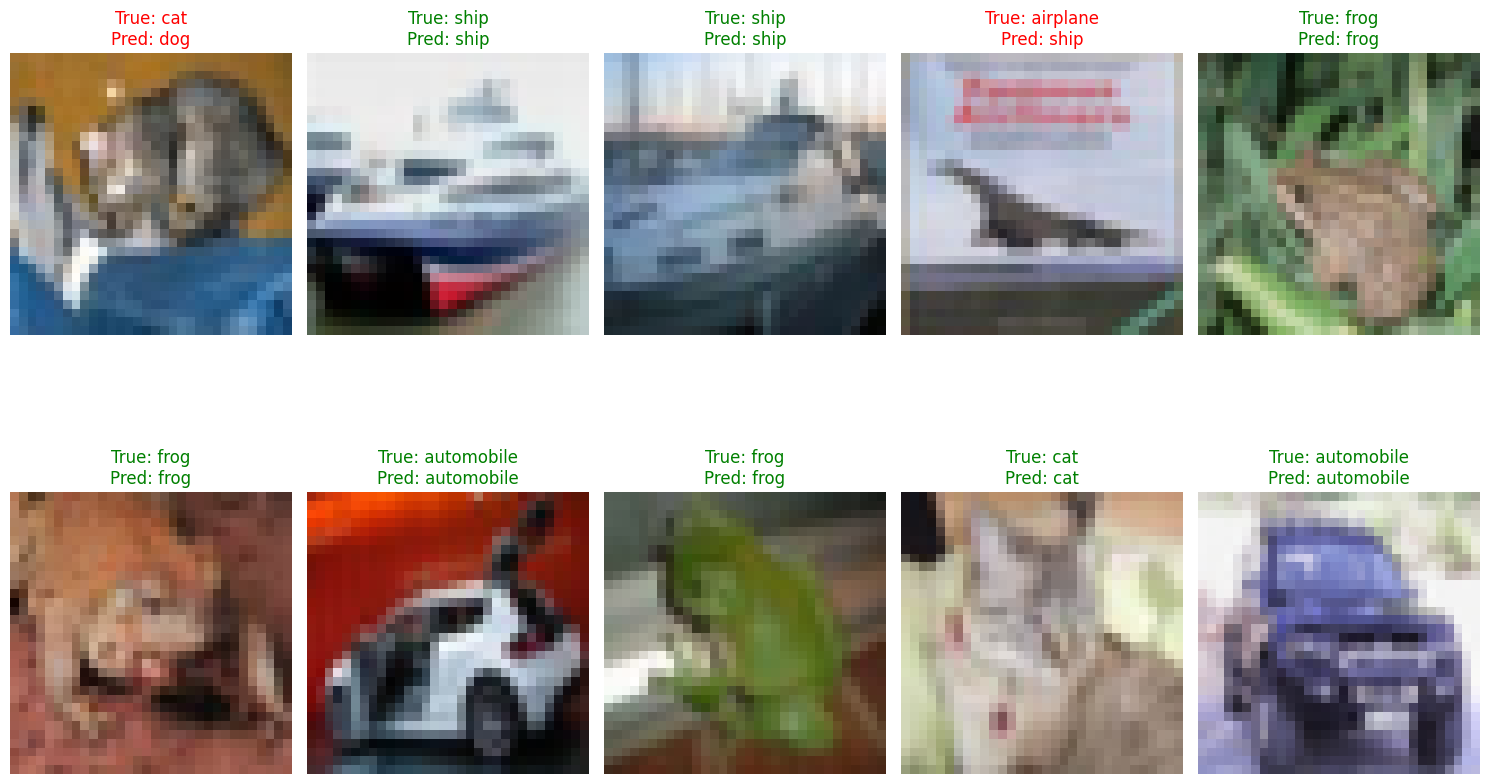

In [22]:
# Visualize model predictions
def plot_model_predictions(model, dataset, class_names, num_samples=10):
    # Get a batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        # Get predictions
        predictions = model.predict(images)

        # Plot the images and predictions
        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i])

            true_class = np.argmax(labels[i])
            pred_class = np.argmax(predictions[i])

            title_color = 'green' if true_class == pred_class else 'red'
            plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}",
                     color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('prediction_samples.png')
        plt.show()
        break

# Visualize some predictions
plot_model_predictions(model, test_dataset, class_names)


In [24]:
# Save the final model
print("Saving the model...")
model.save('cifar10_mobilenet_final.h5')

Saving the model...


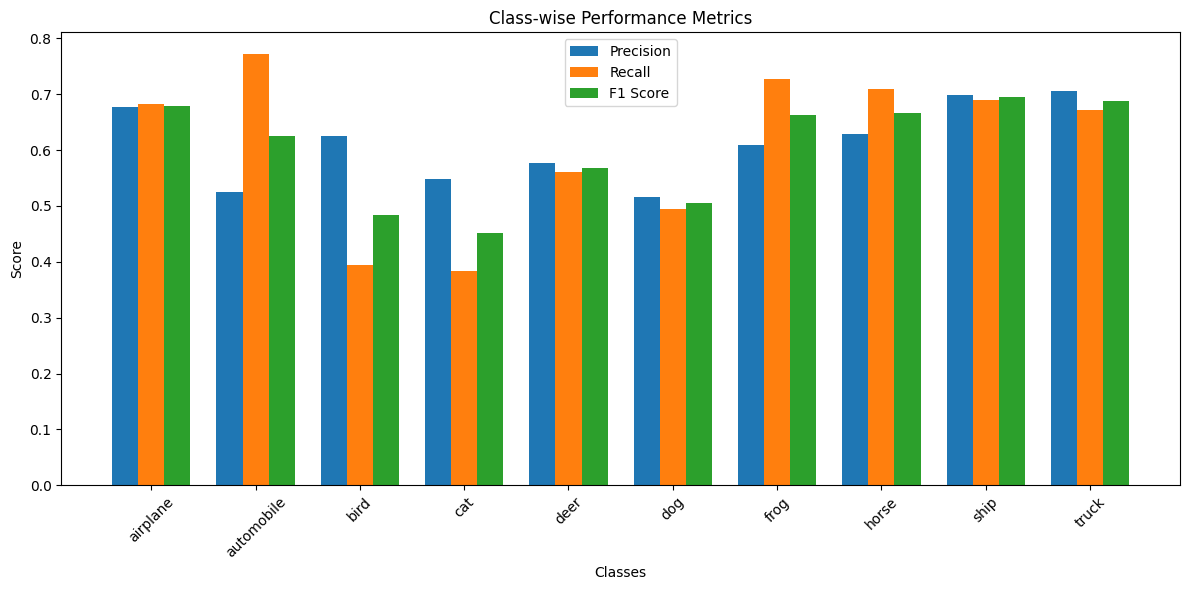

In [25]:
#Class-wise performance analysis
class_precision = np.diag(cm) / np.sum(cm, axis=0)
class_recall = np.diag(cm) / np.sum(cm, axis=1)
class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall)

# Create class-wise performance visualization
plt.figure(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Precision')
plt.bar(x, class_recall, width, label='Recall')
plt.bar(x + width, class_f1, width, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('class_performance.png')
plt.show()

In [27]:
# Final summary
print("\nMobileNetV2 Model Training and Evaluation Summary:")
print("=" * 60)
print(f"Dataset: CIFAR-10 (10 classes, 32x32 RGB images)")
print(f"Model Architecture: MobileNetV2 (Transfer Learning)")
print(f"Training Approach: Two-phase (Frozen base + Fine-tuning)")
print(f"Regularization: Dropout layers (0.5, 0.3)")
print(f"Optimization: Early Stopping, Learning Rate Scheduling")
print(f"Final Metrics:")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Test Precision: {test_precision:.4f}")
print(f"  - Test Recall: {test_recall:.4f}")
print(f"  - F1 Score: {f1_score:.4f}")
print("Model saved as:")
print("cifar10_mobilenet_final.h5")


MobileNetV2 Model Training and Evaluation Summary:
Dataset: CIFAR-10 (10 classes, 32x32 RGB images)
Model Architecture: MobileNetV2 (Transfer Learning)
Training Approach: Two-phase (Frozen base + Fine-tuning)
Regularization: Dropout layers (0.5, 0.3)
Optimization: Early Stopping, Learning Rate Scheduling
Final Metrics:
  - Test Accuracy: 0.6084
  - Test Precision: 0.7944
  - Test Recall: 0.4294
  - F1 Score: 0.5575
Model saved as:
cifar10_mobilenet_final.h5
